In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn as nn
from torch.optim import Adam
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert PIL image to tensor with values in [0, 1]
    transforms.Lambda(lambda x: x * 2 - 1)  # Scale values to [-1, 1]
])
mnist_train = MNIST(root='../datasets/mnist/train/', download=True, transform=transform)
mnist_test = MNIST(root="../datasets/mnist/test/", train=False, download=True, transform=transform)

In [3]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets/mnist/train/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )


In [4]:
print(mnist_test)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../datasets/mnist/test/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )


In [5]:
mnist_train.__getitem__(0)

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [6]:
batch_size = 32
train_dataloader = DataLoader(
    dataset=mnist_train,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=mnist_test,
    batch_size=batch_size,
    shuffle=True
)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.init_size = 7  # Initial size before upsampling
        self.dense = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, z):
        out = self.dense(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(2, 2))
        )
        self.dense = nn.Linear(256 * 2 * 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.dense(out)
        return validity

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
#hyperparameters and config
latent_dim=100
epochs = 200
sample_interval = 10

In [11]:
generator = Generator(latent_dim=latent_dim).to(device=device)
discriminator = Discriminator().to(device=device)

optimizer_g = Adam(params=generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) #as per dcgan paper
optimizer_d = Adam(params=generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCEWithLogitsLoss()
g_losses = []
d_losses = []

In [12]:
#function to sample images from generator:
def sample_images(epoch):
    rows, cols = 5, 5
    with torch.no_grad():
        noise = torch.randn(rows * cols, latent_dim, device=device)
        images = generator(noise).cpu()
        images = 0.5 * images + 0.5 #rescaling to [0, 1] for gray cmap
        fig, axes = plt.subplots(rows, cols)
        idx = 0
        for i in range(rows):
            for j in range(cols):
                axes[i, j].imshow(images[idx].squeeze(), cmap='gray')
                axes[i, j].axis('off')
                idx += 1
        fig.savefig(f"gan_images/{epoch}.png")
        plt.close()

In [13]:
# train loop:
for epoch in range(epochs):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    for i, (images, _) in enumerate(train_dataloader):
        real_images = images.to(device)
        ones = torch.ones(real_images.size(0), 1).to(device) #labels for each batch {real: one, fake: 0}
        zeros = torch.zeros(real_images.size(0), 1).to(device)

        #train discriminator
        optimizer_d.zero_grad()
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)
        # combined_images = torch.cat((real_images, fake_images.detach())) #using batch mixing for better learning
        # combined_labels = torch.cat((ones, zeros))
        # permutation = torch.randperm(n=combined_images.size(0))
        # combined_images = combined_images[permutation]
        # combined_labels = combined_labels[permutation]
        # d_loss = adversarial_loss(discriminator(combined_images), combined_labels)
        d_loss_real = adversarial_loss(discriminator(real_images), ones)
        d_loss_fake = adversarial_loss(discriminator(fake_images), zeros)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        optimizer_d.step()
        d_loss_epoch += d_loss.item()
        
        #train generator
        optimizer_g.zero_grad()
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)
        g_loss = adversarial_loss(discriminator(fake_images), ones)
        g_loss.backward()
        optimizer_g.step()
        g_loss_epoch += g_loss.item()
    
    #calc average batch losses
    d_loss_epoch /= len(train_dataloader)
    g_loss_epoch /= len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs} - D loss: {d_loss_epoch:.4f}, G loss: {g_loss_epoch:.4f}")
    d_losses.append(d_loss_epoch)
    g_losses.append(g_loss_epoch)

    if epoch % sample_interval == 0:
        sample_images(epoch)

Epoch 1/200 - D loss: 0.7267, G loss: 0.7199
Epoch 2/200 - D loss: 0.7256, G loss: 0.7176
Epoch 3/200 - D loss: 0.7253, G loss: 0.7171
Epoch 4/200 - D loss: 0.7251, G loss: 0.7171
Epoch 5/200 - D loss: 0.7248, G loss: 0.7164
Epoch 6/200 - D loss: 0.7247, G loss: 0.7173
Epoch 7/200 - D loss: 0.7241, G loss: 0.7179
Epoch 8/200 - D loss: 0.7239, G loss: 0.7187
Epoch 9/200 - D loss: 0.7233, G loss: 0.7193
Epoch 10/200 - D loss: 0.7226, G loss: 0.7203
Epoch 11/200 - D loss: 0.7229, G loss: 0.7197
Epoch 12/200 - D loss: 0.7233, G loss: 0.7191
Epoch 13/200 - D loss: 0.7230, G loss: 0.7203
Epoch 14/200 - D loss: 0.7228, G loss: 0.7194
Epoch 15/200 - D loss: 0.7234, G loss: 0.7184
Epoch 16/200 - D loss: 0.7235, G loss: 0.7180
Epoch 17/200 - D loss: 0.7226, G loss: 0.7199
Epoch 18/200 - D loss: 0.7218, G loss: 0.7210
Epoch 19/200 - D loss: 0.7221, G loss: 0.7208
Epoch 20/200 - D loss: 0.7221, G loss: 0.7204
Epoch 21/200 - D loss: 0.7214, G loss: 0.7221
Epoch 22/200 - D loss: 0.7221, G loss: 0.72

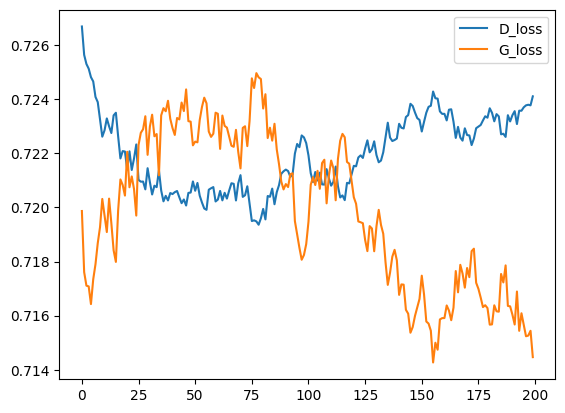

In [14]:
plt.plot(d_losses, label="D_loss")
plt.plot(g_losses, label="G_loss")
plt.legend()
plt.show()